Set the visible GPU for multi GPU environments

In [2]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=0


In [3]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import fastai
from fastai.vision import *
from fastai.callbacks import SaveModelCallback
from fastai.callbacks import *
import os
from train.radam import *
from train.mish_activation import *
from train.loss_broker import *
from train.metrics_broker import *
from data.sampler import FoldSampler
from data.tileimages import *
from evaluation.eval_funcs import evaluate_model_dir 
from model.model_config import ModelConfig
from model.model_utils import load_weights
from model import get_panda_model
from util import move_models_2_savedir
import warnings
from fastai.callbacks import OverSamplingCallback
from train.callbacks import GradientAccumulator

import numpy as np
warnings.filterwarnings("ignore")

fastai.__version__

'1.0.61'

## Variables

In [4]:
#####################################
######### TILE SETTINGS #############

sz = 256 # image tile size
N = 36 #number of tiles per image

# These are tile data specific - check the correct values from preprocessing notebook (mean inverted)
mean = torch.tensor([0.12763948, 0.26959692, 0.17737206])
std = torch.tensor([0.39347589, 0.52878378, 0.42794033])

######################################
############## PATHS #################

# Tile image folder path
TRAIN = '../../train_1_256_256_6x6-skeleton-mask/'
# Path to train.csv
LABELS = '../../prostate-cancer-grade-assessment/train.csv'

SAVE_DIR = './models/256_256_6x6_model_0'
assert not os.path.isdir(SAVE_DIR), "The save dir already exists"

#####################################
############## MODEL ################

# identifier for model selector
# iafoss, conv_branch, gem_concat_pooling, multihead_tilecat,
# iafoss_regr, conv_branch_regr
model_name = "iafoss"

# base cnn encoder. Available options include:
# Facebook semi supervised: resnext50_32x4d_ssl, resnext101_32x4d_ssl
# ResNeSt (imagenet): 'resnest50', 'resnest101', 'resnest200', 'resnest269'
# MXResNet - mish xresnet (no pretrained weights): 'mxresnet18', 'mxresnet34', 'mxresnet50', 'mxresnet101', 'mxresnet152'
arch = "resnext50_32x4d_ssl"
model_n_out = 5 # This is 6 with classification and 5 with ordinal as it predicts only labels >= 1.
final_dropout = 0.9
is_ordinal = True
assert not(is_ordinal and "regr" in model_name), "ordinal mode doesn't work with regular regression"
assert not(is_ordinal and "multihead" in model_name), "ordinal mode doesn't yet support multihead models"

####################################
############# TRAINING #############

n_folds = 4
bs = 11 # decrease this value on CUDA out of memory errors
n_workers = 6
opt_func=Over9000 # optimizer
lr_warmup = 1e-3
max_lr = 1e-4
epochs = 20
is_warmup = False # don't use warmup with flat_and_anneal
lr_sched = "flat_and_anneal" # "one_cycle" | "flat_and_anneal"
gradient_accumulation = 1 # if this is over 1, GA is applied
is_oversampling = False
uniform_augmentations = True # apply the same augmentations to all tiles
shuffle_nonempty_imgs = False
is_pretrained = False # load models from your own dir - When this is False, Imagenet weights are always loaded if they are available for the model.
pretrained_dir = "./models/256_256_6x6_model_0/" # own pre-trained dir

# augementations. see https://docs.fast.ai/vision.transform.html#get_transforms
tfms = get_transforms(max_zoom=1.3,
                      flip_vert=True,
                      max_rotate=15,
                      max_lighting=0.3,
                      xtra_tfms=[])

#####################################
######## LOGGED METADATA ############

# you can add additional optional meta fields to meta dict
# these are saved along the models

meta = {
    "n_folds":n_folds,
    "bs":bs,
    "final_dropout":str(final_dropout),
    "lr_warmup":lr_warmup,
    "is_ordinal":is_ordinal,
    "max_lr":max_lr,
    "is_warmup":is_warmup,
    "opt_func":opt_func.__class__.__name__,
    "lr_sched":lr_sched,
    "gradient_accumulation":str(gradient_accumulation),
    "is_oversampling":is_oversampling,
    "uniform_augmentations":uniform_augmentations,
    "tfms":tfms.__str__(),
    "TRAIN":TRAIN,
    "SAVE_DIR":SAVE_DIR,
    "model_file_prefix":"",
    "is_pretrained":is_pretrained,
    "pretrained_dir":pretrained_dir
}

Enter webhook URL:
········
You must provide a "Slack Incoming Webhook" URL for sending messages. You can generate a webhook URL for your workspace by following this guide: https://api.slack.com/incoming-webhooks
Enter webhook URL:
········


### Initializations

In [3]:
# Training data
sampler = FoldSampler(TRAIN,
                      LABELS,
                      mean,
                      std,
                      N,
                      tfms=tfms, 
                      sz=sz, 
                      bs=bs, 
                      n_folds=n_folds,
                      model_name=model_name,
                      uniform_augmentations=uniform_augmentations,
                      shuffle_nonempty_imgs=shuffle_nonempty_imgs,
                      is_ordinal=is_ordinal,
                      num_workers=n_workers)

In [6]:
# Model
model_func = get_panda_model(model_name, arch=arch, n=model_n_out, final_dropout=final_dropout, num_tiles=N)

Using cache found in /home/joni/.cache/torch/hub/facebookresearch_semi-supervised-ImageNet1K-models_master


In [5]:
# create the model config which is saved along the models
config = ModelConfig(model_name=model_name,
                     arch=arch, 
                     model_n_out=model_n_out,
                     sz=sz,
                     N=N,
                     mean=mean.numpy(),
                     std=std.numpy(),
                     meta=meta)

### Show batch

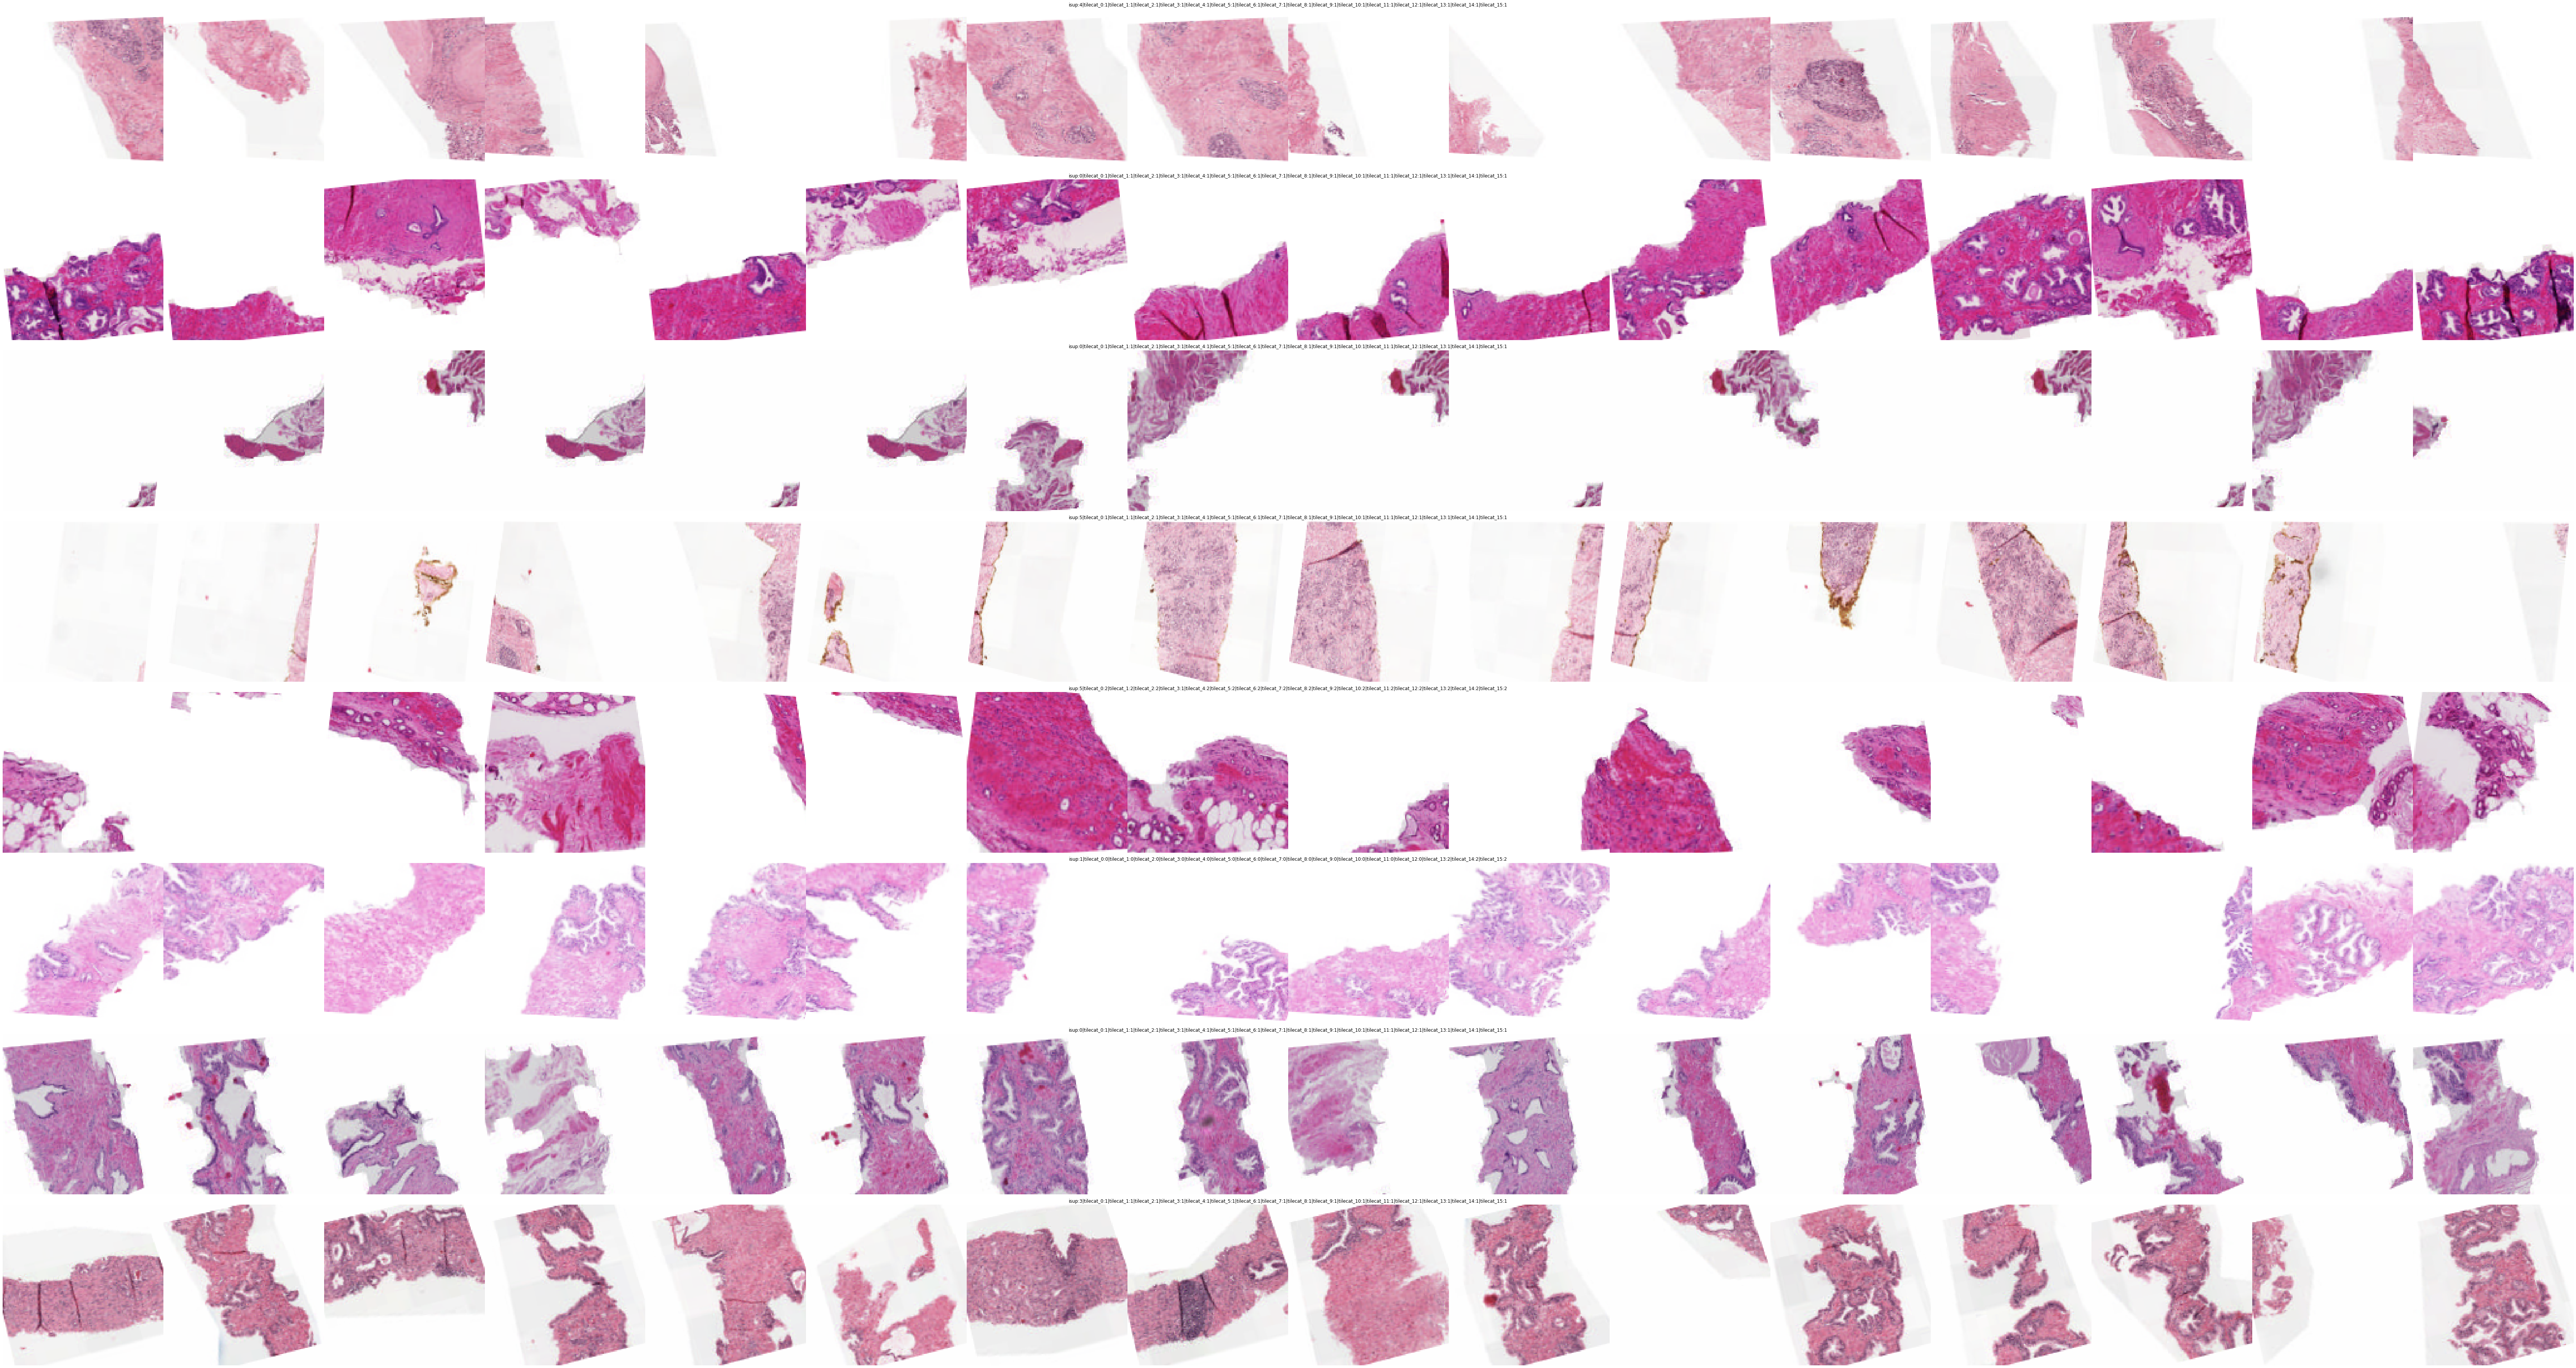

In [6]:
data = sampler.get_data(0)
data.show_batch()

### Loss function

In [7]:
loss_func=get_default_loss(model_name, data, is_ordinal=is_ordinal)

### Metrics 
For visualization and for saaving the best model.

In [8]:
default_metrics, monitor_metric = get_default_metrics(model_name, data=data, is_ordinal=is_ordinal)
print(f'{monitor_metric} is monitored for the best model')

kappa_score is monitored for the best model


In [9]:
model = model_func()

Using cache found in /home/joni/.cache/torch/hub/facebookresearch_semi-supervised-ImageNet1K-models_master


In [10]:
# LR find
if is_pretrained:
    state_dict = load_weights(pretrained_dir, 0)
    model.load_state_dict(state_dict, strict=False)

learn = Learner(data,
                model,
                loss_func=loss_func,
                opt_func=opt_func,
                metrics=default_metrics,
                callback_fns=None
               ).to_fp16()

learn.unfreeze()
learn.clip_grad = 1.0
learn.lr_find()
learn.recorder.plot()

### Training

In [ ]:
def default_callback_fns():
    cb_fns = [ShowGraph]
    if gradient_accumulation > 1:
        accumulator = partial(GradientAccumulator, num_iterations=int(gradient_accumulation))
        cb_fns.append(accumulator)
    return cb_fns

def train_schedule(learn, epochs, max_lr, cbs=[], is_oversampling=False, lr_sched="one_cycle"):
    if is_oversampling:
        cbs.append(OverSamplingCallback(learn))
    
    if lr_sched == "one_cycle":
        learn.fit_one_cycle(
            epochs,
            max_lr=max_lr,
            div_factor=100,
            pct_start=0.0, 
            callbacks = callbacks
        )
    elif lr_sched == "flat_and_anneal":
        learn.fit_fc(
            tot_epochs=epochs,
            lr=max_lr,
            callbacks = cbs
        )
    else:
        raise Exception("lr_sched", f'unknown schedule: {lr_sched}')

In [ ]:
for fold in range(n_folds):
    data = sampler.get_data(fold)
    model = model_func()
    
    if is_pretrained:
        state_dict = load_weights(pretrained_dir, fold)
        model.load_state_dict(state_dict, strict=False)
        
    learn = Learner(data,
                    model,
                    loss_func=loss_func,
                    opt_func=opt_func,
                    metrics=default_metrics,
                    callback_fns=default_callback_fns()
                   ).to_fp16()
    
    learn.clip_grad = 1.0
    
    try:
        learn.split([model.head])
        learn.freeze()
        
        if is_warmup:
            learn.fit_one_cycle(1, lr_warmup)
        
    except Exception as e:
        print(e)
        pass

    learn.unfreeze()
    train_schedule(learn, 
                   epochs, 
                   max_lr,
                   cbs=[
                       SaveModelCallback(learn,
                                         name=f'model',
                                         monitor=monitor_metric),
                       slack_cb
                   ],
                   is_oversampling=is_oversampling,
                   lr_sched=lr_sched
                  )
    # save only state dict (weights) - requires the model when loading
    torch.save(learn.model.state_dict(), f'{fold}.pth')

### Package the models along with configs

In [ ]:
move_models_2_savedir(SAVE_DIR, models=[f'./{fold}.pth' for fold in range(n_folds)])
config.toDir(SAVE_DIR)

### Evaluate

In [ ]:
sampler.is_train = False
evaluate_model_dir(SAVE_DIR, sampler=sampler)